
### Дообучение BERT для задачи NER и его дистилляция

### О проекте

В этом проекте я решал задачу Named Entity Recognition (NER) на самом популярном датасете – [CoNLL-2003](https://paperswithcode.com/dataset/conll-2003). В моём распоряжении предобученный BERT, который необходимо уменьшить без потерь в качестве.

### О датасете

В CoNLL-2003 для именования сущностей используется маркировка **BIO** (Beggining, Inside, Outside), в которой метки означают следующее:

- *B-{метка}* – начало сущности *{метка}*
- *I-{метка}* – продолжнение сущности *{метка}*
- *O* – не сущность

Всего в датасете есть 9 разных меток.
- O – слову не соответствует ни одна сущность.
- B-PER/I-PER – слово или набор слов соответстует определенному _человеку_.
- B-ORG/I-ORG – слово или набор слов соответстует определенной _организации_.
- B-LOC/I-LOC – слово или набор слов соответстует определенной _локации_.
- B-MISC/I-MISC – слово или набор слов соответстует сущности, которая не относится ни к одной из предыдущих. Например, национальность, произведение искусства, мероприятие и т.д.

Приступим!

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import torch
from torch import nn
from transformers import AutoModelForTokenClassification, AutoTokenizer, DataCollatorForTokenClassification
from torch.utils.data import DataLoader
from typing import Dict, List

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
device

device(type='cuda')

In [3]:
!wget -O 'train.txt' -q 'https://www.dropbox.com/scl/fi/u2vggadg5pwpo9jkmtxta/train-1.txt?rlkey=tmk43yyqxeq1abv48t9oovv7h&st=kpknrrb3&dl=0'
!wget -O 'valid.txt' -q 'https://www.dropbox.com/scl/fi/rtu61xd20n6q7dpzyjle3/valid-1.txt?rlkey=frvrorqq8hbrsvpbodmatgc5m&st=cogqld5f&dl=0'

Напишем функцию `read_conll2003` для чтения датасета. Внутри она должна проитерироваться по всем строкам файла и для каждого примера составить словарь с полями `words` и `tags` (слова и тэги текста соответственно). На выход функция возвращает список полученных словарей. Тексты в файле разделяются переносом строки `\n`, а слова и тэги – проблелом.
```
! head -n 15 CoNLL2003/train.txt

EU B-ORG
rejects O
German B-MISC
call O
to O
boycott O
British B-MISC
lamb O
. O

Peter B-PER
Blackburn I-PER

BRUSSELS B-LOC
1996-08-22 O
```

In [5]:
def read_conll2003(path: str) -> List[Dict[str, str]]:
    """
    Read data in CoNNL like format.
    """

    with open(path, 'r') as fd:
        texts = list(fd)

    dataset = []
    words = []
    tags = []
    for line in texts:
        line = line[:-1]
        if len(line) == 0:
            dataset.append({'words': words, 'tags': tags})
            words = []
            tags = []
        else:
            word, tag = line.split(' ')
            words.append(word)
            tags.append(tag)
    return dataset

Прочитаем тренировочный и валидационный датасеты.

In [6]:
train_dataset = read_conll2003("train.txt")
valid_dataset = read_conll2003("valid.txt")

tags = ['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']

In [7]:
sample = train_dataset[0]

assert sample['words'] == ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
assert sample['tags'] == ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']

for w, t in zip(sample['words'], sample['tags']):
    print(f'{w}\t{t}')

EU	B-ORG
rejects	O
German	B-MISC
call	O
to	O
boycott	O
British	B-MISC
lamb	O
.	O


На протяжении всего проекта мы будем использовать _cased_ версию BERT, то есть токенизатор будет учитывать регистр слов. Для задачи NER регистр важен, так как имена и названия организаций или предметов искусства часто пишутся с большой буквы, и будет глупо прятать от модели такую информацию.

In [8]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Заметим, что при токенизации слова могут разделиться на несколько токенов (как слово `lamb` из примера ниже), из-за чего появится несоответствие между числом токенов и тэгов. Это несоответствие нам придется устранить вручную.

In [9]:
inputs = tokenizer(sample['words'], is_split_into_words=True)
print('Слова: ', sample['words'])
print('Токены:', inputs.tokens())

Слова:  ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
Токены: ['[CLS]', 'EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'la', '##mb', '.', '[SEP]']


К счастью, из выхода токенизатора можно достать список с номерами слов, к которым относится каждый токен. Если номер встретился несколько раз подряд, то слово разделилось. Специальные символы не принадлежат никакому слову, поэтому их номер – `None`.

In [10]:
inputs.word_ids()

[None, 0, 1, 2, 3, 4, 5, 6, 7, 7, 8, None]

Напишем метод `get_inputs_and_aligned_labels` класса `Dataset`. Он принимает в себя объект из прочитанного выше датасета, токенизирует слова и выравнивает тэги. Выравнивание происходит следующим образом: если токен пренадлежит тому же слову, что и предыдущий токен, и его тэг начинается на `B`, то надо поменять `B` на `I`, потому что это уже продолжение сущности; в любом другом случае тэг токена остается таким же, какой был у соответствующего ему слова.

Метод позвращает словарь с полями `input_ids` – результат токенизации, `labels` – индексы тэгов для каждого токена из маппинга `tag2id`, для специальных символов в качестве лейбла укажите -100, так как это значение по умолчанию, которое игнорируется при подсчете кросс-энтропии в классе `CrossEntropyLoss`.

In [11]:
class Dataset:
    def __init__(self, raw_dataset: List[Dict[str, str]], tag2id: Dict[str, int]):
        """
        :params:
        raw_dataset: output of read_conll2003 function
        tag2id: mapping from tag name to its id
        """
        self.dataset = raw_dataset
        self.tag2id = tag2id

    def get_inputs_and_aligned_labels(self, sample):
        """
        Aligns tags with tokens and returns dict with token ids and tag ids.
        """
        tokenized = tokenizer(sample['words'], is_split_into_words=True)
        tags = sample['tags']

        input_ids = tokenized.input_ids
        word_ids = tokenized.word_ids()[1:-1]
        labels = [-100]
        for i, id in enumerate(word_ids):
            if i == 0 or id != word_ids[i-1] or tags[id] == 'O':
                labels.append(self.tag2id[tags[id]])
            else:
                a, b = tags[id].split('-')
                labels.append(self.tag2id[f'I-{b}'])
        labels.append(-100)

        return {
            'input_ids': input_ids,
            'labels': labels
        }

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        return self.get_inputs_and_aligned_labels(sample)

    def __len__(self):
        return len(self.dataset)

In [12]:
tag2id = {tag: i for i, tag in enumerate(tags)}
id2tag = {i: tag for tag, i in tag2id.items()}

print(train_dataset[0])

train_data = Dataset(train_dataset, tag2id)
valid_data = Dataset(valid_dataset, tag2id)

{'words': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'tags': ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']}


In [13]:
sample = train_data[0]
input_ids, labels = sample['input_ids'], sample['labels']

assert input_ids == [101, 7270, 22961, 1528, 1840, 1106, 21423, 1418, 2495, 12913, 119, 102]
assert labels == [-100, 2, 8, 1, 8, 8, 8, 1, 8, 8, 8, -100]

for idx, token, label in zip(input_ids, tokenizer.convert_ids_to_tokens(input_ids), labels):
    tag = id2tag[label] if label != -100 else ''
    print(f'{idx}\t{token}\t{label}\t{tag}')

101	[CLS]	-100	
7270	EU	2	B-ORG
22961	rejects	8	O
1528	German	1	B-MISC
1840	call	8	O
1106	to	8	O
21423	boycott	8	O
1418	British	1	B-MISC
2495	la	8	O
12913	##mb	8	O
119	.	8	O
102	[SEP]	-100	


In [14]:
sample = train_data[2]
input_ids, labels = sample['input_ids'], sample['labels']
for idx, token, label in zip(input_ids, tokenizer.convert_ids_to_tokens(input_ids), labels):
    tag = id2tag[label] if label != -100 else ''
    print(f'{idx}\t{token}\t{label}\t{tag}')

101	[CLS]	-100	
26660	BR	0	B-LOC
13329	##US	4	I-LOC
12649	##SE	4	I-LOC
15928	##LS	4	I-LOC
1820	1996	8	O
118	-	8	O
4775	08	8	O
118	-	8	O
1659	22	8	O
102	[SEP]	-100	


На данный момент наш датасет возвращает по индексу списки токенов и меток, но при формировании батча нам надо их дополнить паддингами. Для этого существует Collator – класс, который вызывается при формировании батча. Он принимает набор произвольных объектов из датасета и делает из них тензоры согласно инструкциям. Для задачи классификации последовательности имеется специальный `DataCollatorForTokenClassification`, который добавляет паддинги к токенам и меткам, что нам собственно и нужно.

In [15]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [16]:
batch = data_collator([train_data[i] for i in range(2)])
print('Поля:\n', batch.keys())
print('\nИндексы токенов:\n', batch['input_ids'])
print('\nИндексы меток:\n', batch['labels'])

Поля:
 dict_keys(['input_ids', 'attention_mask', 'labels'])

Индексы токенов:
 tensor([[  101,  7270, 22961,  1528,  1840,  1106, 21423,  1418,  2495, 12913,
           119,   102],
        [  101,  1943, 14428,   102,     0,     0,     0,     0,     0,     0,
             0,     0]])

Индексы меток:
 tensor([[-100,    2,    8,    1,    8,    8,    8,    1,    8,    8,    8, -100],
        [-100,    3,    7, -100, -100, -100, -100, -100, -100, -100, -100, -100]])


Теперь мы готовы обернуть всю нашу красоту в `DataLoader`, по которому будем итерироваться при обучении.

In [17]:
batch_size = 32

train_loader = DataLoader(
    train_data,
    collate_fn=data_collator,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=True
)

valid_loader = DataLoader(
    valid_data,
    collate_fn=data_collator,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=False
)

### Метрика

Для оценки качества NER чаще всего используется F1-мера. Разделяют два метода подсчета метрики:
1) Token-level: считается правильность предсказания отденьной метки для каждого токена.
2) Entity-level: считается правильность предсказания метки для всей сущности целиком независимо от того, сколько слов или токенов в нее входит.

Обычно предпочтение отдается второму способу, так как иначе, во-первых, качество зависит от токенизации, а во-вторых, если сущность состоит из нескольких слов и модель выставляет словам разные метки, то становится непонятно, к какому именно классу относить данную сущность. Для практики такой результат настолько же плох, насколько полное неугадывание класса, поэтому странно давать за это баллы.

Заметим, что предсказание `[I-PER', 'I-PER]` при верном `[B-PER', 'I-PER]` считается корректным, так как из него можно однозначно восстановить ответ, догадавшись, что не первом месте должно стоять `B-`. В то же время при верном `[B-PER', 'B-PER]` такое предсказание корректным не будет.

Для подсчета метрики будем использовать уже готовое [решение](https://huggingface.co/spaces/evaluate-metric/seqeval) из библиотеки `seqeval` (`huggingface`).

In [18]:
%pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=78b59318675e392b58e430963bcd440ffc319755c248bab6c761c5f8d877f7dd
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [19]:
from seqeval.metrics import f1_score, accuracy_score

In [20]:
# here are 7 labels in total, we guessed correctly 4 of them.

predictions = [['O', 'I-PER', 'I-PER', 'O'], ['I-PER', 'I-PER', 'O']]
references = [['O', 'B-PER', 'B-PER', 'O'], ['B-PER', 'I-PER', 'O']]
acc = accuracy_score(predictions, references)
f1 = f1_score(references, predictions)
acc, f1

(0.5714285714285714, 0.4)

In [26]:
def calc_f1(predictions: List[List[int]], labels: List[List[int]]):
    """
    :params:
    predictions: list of lists of predicted labels
    labels: list of lists of ground truth labels
    """
    text_labels = [[id2tag[l] for l in label if l != -100] for label in labels]
    text_predictions = []
    for i in range(len(text_labels)):
        # +1 because we skip the first ([CLS]) token
        sample_text_preds = [id2tag[predictions[i][j + 1]] for j in range(len(text_labels[i]))]
        text_predictions.append(sample_text_preds)

    return f1_score(text_labels, text_predictions)

### Модель

В качестве начальной модели мы будем использовать предобученный BERT, а если быть точнее `bert-base-cased` из библиотеки `huggingface`. Он содержит 107М параметров. В последующих заданиях мы будем реализовывать методы для уменьшения его размеров с минимальной потерей качества.

Для классификации последовательностей в `transformers` существует специальная обертка `AutoModelForTokenClassification`. Воспользуемся ею и обернем нашу модель.

In [22]:
model_teacher = AutoModelForTokenClassification.from_pretrained('bert-base-cased', id2label=id2tag, label2id=tag2id).to(device)
print('Number of parameters:', sum([p.numel() for p in model_teacher.parameters()]))

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of parameters: 107726601


Все методы уменьшения размерности основываются на том, что у нас есть некоторая обученная модель. Сейчас у нас есть предобученный BERT, но на задачу MLM, а не NER. Дообучим BERT на нашем датасете.

In [23]:
from tqdm.notebook import tqdm

from IPython.display import clear_output

import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses, train_metrics, val_metrics):
    clear_output()
    print(f'Train loss: {train_losses[-1]}. Val loss: {val_losses[-1]}')
    print(f'Train F1: {train_metrics[-1]}. Val metrics: {val_metrics[-1]}')
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].plot(train_losses, label='train')
    axs[0].plot(val_losses, label='val')
    axs[0].set_title('loss')
    axs[0].legend()

    axs[1].plot(train_metrics, label='train')
    axs[1].plot(val_metrics, label='val')
    axs[1].set_title('F1')
    axs[1].legend()

    plt.show()

def train_epoch(model, optimizer, train_loader):
    train_loss = 0.0
    train_f1 = 0.0
    model.train()
    for batch in tqdm(train_loader):
        batch['input_ids'] = batch['input_ids'].to(device)
        batch['attention_mask'] = batch['attention_mask'].to(device)
        batch['labels'] = batch['labels'].to(device)

        optimizer.zero_grad()
        hf_output = model(**batch)
        loss = hf_output.loss
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch['input_ids'].size()[0]

        pred_labels = hf_output.logits.argmax(dim=-1).cpu().tolist()
        real_labels = batch['labels'].cpu().tolist()
        train_f1 += calc_f1(pred_labels, real_labels) * batch['input_ids'].size()[0]

    train_loss /= len(train_loader.dataset)
    train_f1 /= len(train_loader.dataset)

    return train_loss, train_f1

@torch.no_grad()
def validation_epoch(model, val_loader):
    val_loss = 0.0
    val_f1 = 0.0
    model.eval()
    for batch in tqdm(val_loader):
        batch['input_ids'] = batch['input_ids'].to(device)
        batch['attention_mask'] = batch['attention_mask'].to(device)
        batch['labels'] = batch['labels'].to(device)

        hf_output = model(**batch)
        loss = hf_output.loss

        val_loss += loss.item() * batch['input_ids'].size()[0]
        pred_labels = hf_output.logits.argmax(dim=-1).cpu().tolist()
        real_labels = batch['labels'].cpu().tolist()
        val_f1 += calc_f1(pred_labels, real_labels) * batch['input_ids'].size()[0]

    val_loss /= len(val_loader.dataset)
    val_f1 /= len(val_loader.dataset)
    return val_loss, val_f1

def train(model, optimizer, train_loader, val_loader, num_epochs):
    train_losses = []
    val_losses = []
    train_f1 = []
    val_f1 = []

    for epoch in range(num_epochs):
        train_loss, train_metric = train_epoch(model, optimizer, train_loader)
        val_loss, val_metric = validation_epoch(model, val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_f1.append(train_metric)
        val_f1.append(val_metric)

        plot_losses(train_losses, val_losses, train_f1, val_f1)


Train loss: 0.006763648866265256. Val loss: 0.06687840394164042
Train F1: 0.9882239416275047. Val metrics: 0.9360059282773404


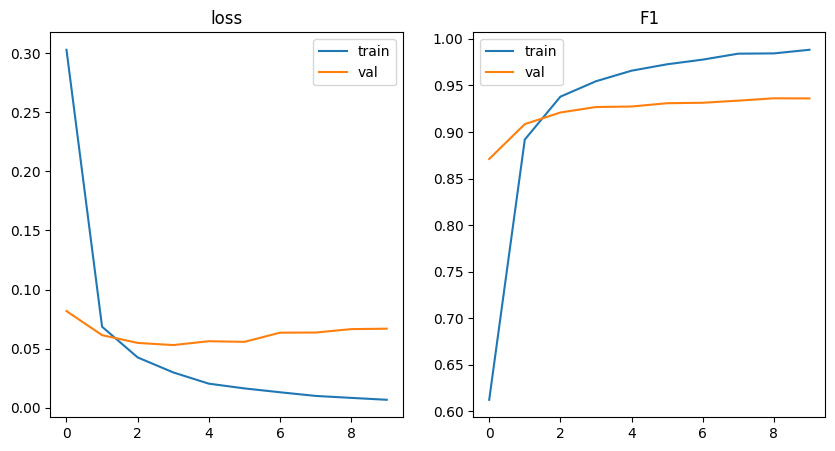

In [24]:
optimizer = torch.optim.Adam(model_teacher.parameters(), lr=1e-5)
train(model_teacher, optimizer, train_loader, valid_loader, num_epochs=10)

### Embedding factorization

Можно заметить, что на данный момент матрица эмбеддингов занимает $V \cdot H = 28996 \cdot 768 = 22.268.928$ параметров. Это целая пятая часть от всей модели! Давайте попробуем с этим что-то сделать. В вариации [ALBERT](https://arxiv.org/pdf/1909.11942.pdf) предлагается факторизовать матрицу эмбеддингов в произведение двух небольших матриц. Таким образом, параметры эмбеддингов будут содержать $V \cdot E + E \cdot H$ элементов, что гораздо меньше, если $H \gg E$. Авторы выбирают $E = 128$, однако ничего не мешает вам взять значение меньше.

Заменим слой эмбеддингов на описанную факторизацию и дообучим полученную в предыдущем задании модель.


In [25]:
model_albert = AutoModelForTokenClassification.from_pretrained('bert-base-cased', id2label=id2tag, label2id=tag2id).to(device)
print('Number of parameters BERT:', sum([p.numel() for p in model_albert.parameters()]))

U, S, V = torch.svd(model_albert.bert.embeddings.word_embeddings.weight.data)
emb_weights = U @ torch.diag(S)
emb_weights = emb_weights[:, :128]
print(emb_weights.size())
linear_weights = V
linear_weights = linear_weights[:, :128]
print(linear_weights.size())

embedding_layer = nn.Embedding(tokenizer.vocab_size, 128, padding_idx=0)
embedding_layer.weight.data = nn.Parameter(emb_weights.contiguous())
linear_layer = nn.Linear(128, 768, bias=False)
linear_layer.weight.data = nn.Parameter(linear_weights.contiguous())

model_albert.bert.embeddings.word_embeddings = nn.Sequential(
    embedding_layer,
    linear_layer
)
model_albert = model_albert.to(device)
print('Number of parameters ALBERT:', sum([p.numel() for p in model_albert.parameters()]))

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of parameters BERT: 107726601
torch.Size([28996, 128])
torch.Size([768, 128])
Number of parameters ALBERT: 89267465


Train loss: 0.015286159287425584. Val loss: 0.08336068876638665
Train F1: 0.9717468301653547. Val metrics: 0.9216639300054713


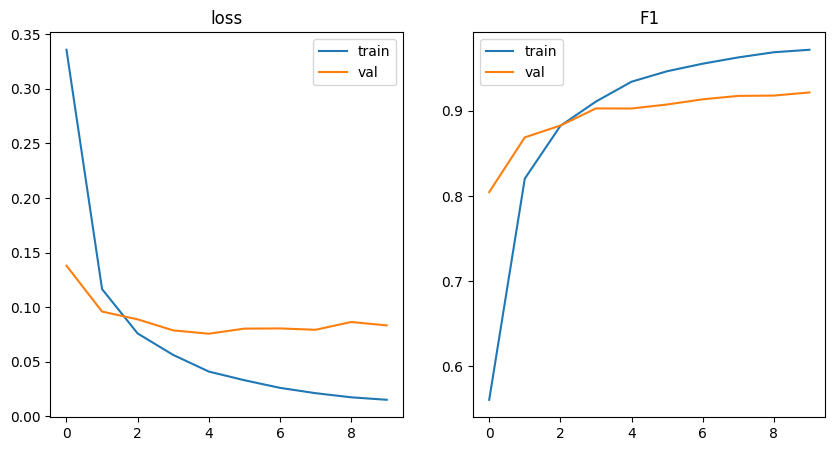

In [27]:
optimizer = torch.optim.Adam(model_albert.parameters(), lr=1e-5)
train(model_albert, optimizer, train_loader, valid_loader, num_epochs=10)

### Дистилляция знаний

Дистилляция знаний – это парадигма обучения, в которой знания модели-учителя дистиллируются в модель-ученика. Учеником может быть произвольная модель меньшего размера, решающая ту же задачу. При дистилляции используются два функционала ошибки:

1. Стандартная кросс-энтропия.
1. Функция, задающая расстояние между распределениями предсказаний учителя и ученика. Чаще всего используют кросс-энтропию или KL-дивергенцию.

При этом для того, чтобы распределение предсказаний учителя не было таким вырожденным используют softmax с температурой больше 1, например, 2 или 5.

<img src="https://intellabs.github.io/distiller/imgs/knowledge_distillation.png">

Реализуем метод дистилляции знаний, изображенный на картинке. Для подсчета ошибки между предсказаниями ученика и учителя будем использовать KL-дивергенцию (`nn.KLDivLoss(reduction="batchmean")`). В качестве учителя используем дообученный нами выше BERT.

In [28]:
from transformers import BertConfig

config = BertConfig(
    num_hidden_layers=6, hidden_size=512,
    num_attention_heads=8, id2label=id2tag,
    label2id=tag2id, bos_token_id=101, eos_token_id=102, pad_id=0,
    vocab_size=28996
)
model_learner = AutoModelForTokenClassification.from_config(config).to(device)
print('Number of parameters:', sum([p.numel() for p in model_learner.parameters()]))

Number of parameters: 40326665


In [29]:
from tqdm.notebook import tqdm

from IPython.display import clear_output

import matplotlib.pyplot as plt

import torch.nn.functional as F

def plot_kd_losses(train_loss_hard, val_loss_hard, train_loss_soft, val_loss_soft, train_metrics, val_metrics, lr):
    clear_output()
    print(f'Train loss hard: {train_loss_hard[-1]}. Val loss hard: {val_loss_hard[-1]}')
    print(f'Current LR: {lr}')
    print(f'Val loss soft: {train_loss_soft[-1]}. Val loss soft: {val_loss_soft[-1]}')
    print(f'Train F1: {train_metrics[-1]}. Val F1: {val_metrics[-1]}')
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))

    axs[0].plot(train_loss_hard, label='train')
    axs[0].plot(val_loss_hard, label='val')
    axs[0].set_title('hard loss')
    axs[0].legend()

    axs[1].plot(train_loss_soft, label='train')
    axs[1].plot(val_loss_soft, label='val')
    axs[1].set_title('soft loss')
    axs[1].legend()

    axs[2].plot(train_metrics, label='train')
    axs[2].plot(val_metrics, label='val')
    axs[2].set_title('F1')
    axs[2].legend()

    plt.show()

def train_kd_epoch(model_teacher, model_student, optimizer, train_loader, t, scheduler):
    train_loss_hard = 0.0
    train_loss_soft = 0.0
    train_f1 = 0.0
    model_student.train()
    for batch in tqdm(train_loader):
        batch['input_ids'] = batch['input_ids'].to(device)
        batch['attention_mask'] = batch['attention_mask'].to(device)
        batch['labels'] = batch['labels'].to(device)

        optimizer.zero_grad()
        hf_student_output = model_student(**batch)
        with torch.no_grad():
          hf_teacher_output = model_teacher(**batch)

        student_logits = torch.permute(hf_student_output.logits, (0, 2, 1))
        teacher_logits = torch.permute(hf_teacher_output.logits, (0, 2, 1))

        loss_hard = F.cross_entropy(input=student_logits, target=batch['labels'])
        loss_soft = F.kl_div(
            input=F.log_softmax(student_logits / t, dim=1),
            target=F.log_softmax(teacher_logits / t, dim=1),
            reduction='batchmean', log_target=True
        )
        loss = loss_hard + loss_soft

        loss.backward()
        optimizer.step()

        train_loss_hard += loss_hard.item() * batch['input_ids'].size()[0]
        train_loss_soft += loss_soft.item() * batch['input_ids'].size()[0]

        pred_labels = student_logits.argmax(dim=1).cpu().tolist()
        real_labels = batch['labels'].cpu().tolist()
        train_f1 += calc_f1(pred_labels, real_labels) * batch['input_ids'].size()[0]

        scheduler.step()

    train_loss_hard /= len(train_loader.dataset)
    train_loss_soft /= len(train_loader.dataset)
    train_f1 /= len(train_loader.dataset)

    return train_loss_hard, train_loss_soft, train_f1

@torch.no_grad()
def validation_kd_epoch(model_teacher, model_student, val_loader, t):
    val_loss_hard = 0.0
    val_loss_soft = 0.0
    val_f1 = 0.0
    model_student.eval()
    for batch in tqdm(val_loader):
        batch['input_ids'] = batch['input_ids'].to(device)
        batch['attention_mask'] = batch['attention_mask'].to(device)
        batch['labels'] = batch['labels'].to(device)

        hf_student_output = model_student(**batch)
        hf_teacher_output = model_teacher(**batch)
        student_logits = torch.permute(hf_student_output.logits, (0, 2, 1))
        teacher_logits = torch.permute(hf_teacher_output.logits, (0, 2, 1))

        loss_hard = F.cross_entropy(input=student_logits, target=batch['labels'])
        loss_soft = F.kl_div(
            input=F.log_softmax(student_logits / t, dim=1),
            target=F.log_softmax(teacher_logits / t, dim=1),
            reduction='batchmean', log_target=True
        )
        loss = loss_hard + loss_soft

        val_loss_hard += loss_hard.item() * batch['input_ids'].size()[0]
        val_loss_soft += loss_soft.item() * batch['input_ids'].size()[0]
        pred_labels = student_logits.argmax(dim=1).cpu().tolist()
        real_labels = batch['labels'].cpu().tolist()
        val_f1 += calc_f1(pred_labels, real_labels) * batch['input_ids'].size()[0]

    val_loss_hard /= len(val_loader.dataset)
    val_loss_soft /= len(val_loader.dataset)
    val_f1 /= len(val_loader.dataset)
    return val_loss_hard, val_loss_soft, val_f1

def train_knowledge_distillation(model_teacher, model_student, optimizer, train_loader, val_loader, num_epochs, scheduler, temperature: int = 10):
    train_losses_hard = []
    val_losses_hard = []
    train_losses_soft = []
    val_losses_soft = []

    train_f1 = []
    val_f1 = []

    for epoch in range(num_epochs):
        train_loss_hard, train_loss_soft, train_metric = train_kd_epoch(model_teacher, model_student, optimizer, train_loader, temperature, scheduler)
        val_loss_hard, val_loss_soft, val_metric = validation_kd_epoch(model_teacher, model_student, val_loader, temperature)

        train_losses_hard.append(train_loss_hard)
        val_losses_hard.append(val_loss_hard)
        train_losses_soft.append(train_loss_soft)
        val_losses_soft.append(val_loss_soft)

        train_f1.append(train_metric)
        val_f1.append(val_metric)

        plot_kd_losses(train_losses_hard, val_losses_hard, train_losses_soft, val_losses_soft, train_f1, val_f1, scheduler.get_lr()[0])

In [30]:
import math

class CosineAnnealingWithWarmupLR(torch.optim.lr_scheduler._LRScheduler):

    def __init__(self, optimizer, warmup_steps: int, max_steps: int):
        self.warmup = warmup_steps
        self.max_steps = max_steps
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + math.cos(math.pi * epoch / self.max_steps))
        lr_factor *= min(epoch / self.warmup, 1.0)
        return lr_factor

In [31]:
optimizer = torch.optim.Adam(model_learner.parameters(), lr=3e-4)
scheduler = CosineAnnealingWithWarmupLR(optimizer=optimizer, warmup_steps=800, max_steps=469 * 25)

Train loss hard: 0.0022906049867668895. Val loss hard: 0.29253439108019996
Current LR: 0.0
Val loss soft: 0.22825951720730223. Val loss soft: 1.3031949457496104
Train F1: 0.9964919707428352. Val F1: 0.8009748622240677


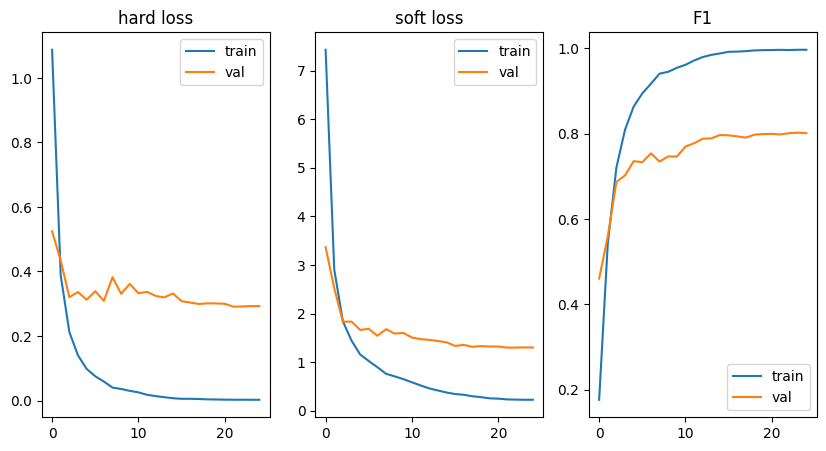

In [32]:
train_knowledge_distillation(
    model_teacher=model_teacher, model_student=model_learner, optimizer=optimizer, train_loader=train_loader, val_loader=valid_loader, num_epochs=25, temperature = 5, scheduler=scheduler
)